In [48]:
import torch
from torchvision import models
import torch.nn as nn
import pandas as pd
import os
import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import higher
import random
from sklearn.model_selection import ParameterGrid
import time
import copy
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import lime
from lime import lime_image
import shap
import numpy as np
import glob

# Dataset

In [49]:
spineData : str = "../data/spine"
normalPath : str = "../data/spine/Normal"
osteopenia : str = "../data/spine/Osteopenia"
Osteoporosis : str = "../data/spine/Osteoporosis"

In [50]:
df = pd.DataFrame(columns=["path", "category"])

def list_images(folder_path):
    extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.gif', '*.tiff', '*.webp')
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
    return [os.path.abspath(img) for img in image_paths]

def assignCategory(df : pd.DataFrame, images : list[str], category : str) -> pd.DataFrame:
    for image in images:
        new_row = pd.DataFrame([{ "path": image, "category": category }])
        df = pd.concat([df, new_row], ignore_index=True)
    return df

df = assignCategory(df, list_images(normalPath), "Normal")
df = assignCategory(df, list_images(osteopenia), "Osteopenia")
df = assignCategory(df, list_images(Osteoporosis), "Osteoporosis")


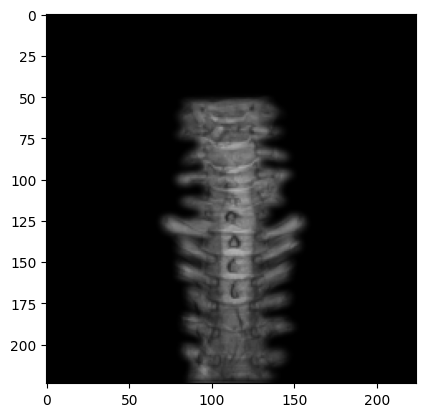

In [51]:
class Xray(Dataset):
    def __init__(self, df : pd.DataFrame):
        self.df = df
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["category"]
        label_map = {"Normal": 0, "Osteopenia": 1, "Osteoporosis": 2}
        label = torch.tensor(label_map[label], dtype=torch.long)
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        return image, label

xrays = Xray(df)
image = xrays[4][0]
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)

In [52]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(xrays, [train_size, test_size])

trainLoader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
testLoader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [53]:
def get_mobilenet_with_dropout(dropout_rate=0.0, num_classes=3):
    model = models.mobilenet_v2(pretrained=True)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_features, num_classes)
    )
    return model

best_params = {'batch_size': 8, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
best_model = get_mobilenet_with_dropout(dropout_rate=best_params['dropout_rate'], num_classes=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'best_mobilenet_model.pth'
best_model.load_state_dict(torch.load(model_path, map_location=device))
best_model = best_model.to(device)
print(f"Model loaded from {model_path}")


/home/narasima/anaconda3/envs/.RL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narasima/anaconda3/envs/.RL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from best_mobilenet_model.pth


In [54]:
def get_gradcam_visualization(model, image, target_class=None):
    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    input_tensor = image.unsqueeze(0).to(device)
    targets = [ClassifierOutputTarget(target_class)] if target_class is not None else None
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    return show_cam_on_image(image.permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)

In [55]:
def get_lime_explanation(model, image):
    def batch_predict(images):
        model.eval()
        batch = torch.stack([torch.Tensor(img).permute(2, 0, 1) for img in images])  # Fix shape (H, W, C) → (C, H, W)
        batch = batch.to(device)  # Move to GPU if available
        with torch.no_grad():
            logits = model(batch)
        return F.softmax(logits, dim=1).cpu().numpy()

    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image.permute(1,2,0).numpy(), batch_predict, top_labels=3, hide_color=0, num_samples=1000
    )
    return explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

In [56]:
def get_shap_values(model, background_loader, image):
    background = torch.stack([x for x, _ in next(iter(background_loader))])
    e = shap.DeepExplainer(model, background)
    return e.shap_values(image.unsqueeze(0))

In [88]:
def visualize_explanations(model, image, target_class=None,index=0):
    plt.figure(figsize=(15, 5))
    plt.subplot(141)
    plt.title('Original Image')
    plt.imshow(image.permute(1,2,0).numpy())
    plt.axis('off')
    
    plt.subplot(142)
    plt.title('Grad-CAM')
    plt.imshow(get_gradcam_visualization(model, image, target_class))
    plt.axis('off')
    plt.savefig(f"output/gradcam_{index}.svg" ,bbox_inches='tight')
    plt.savefig(f"output/gradcam_{index}.jpg" ,bbox_inches='tight')
    plt.show()
    


0


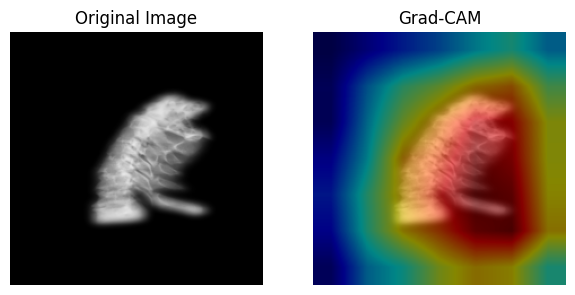

1


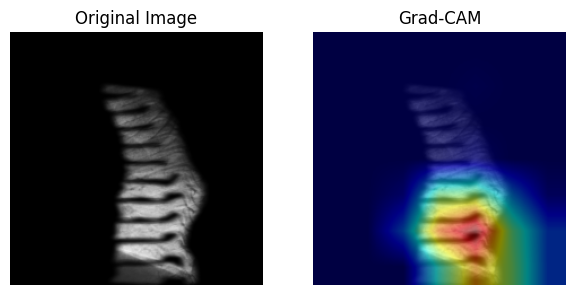

7


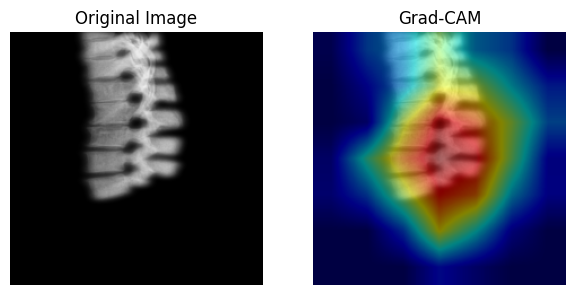

14


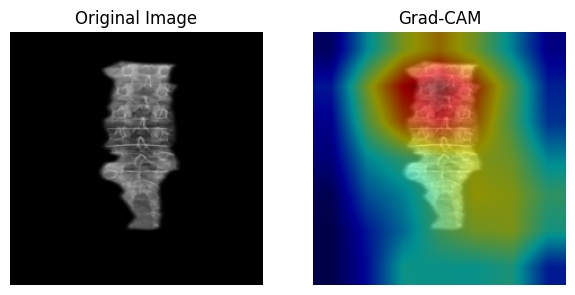

18


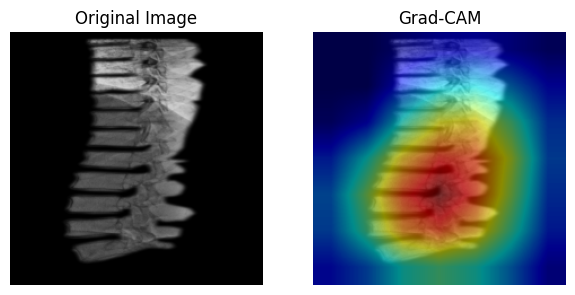

In [89]:
for i in [0,1,7,14,18]:
    sample_image, sample_label = test_dataset[i]
    print(i)
    visualize_explanations(best_model, sample_image, target_class=sample_label,index=i)
